# **Good to Test Which Model is the Best**

# GPU Hill Climbing
This notebook demonstrates how to perform hill climbing. For each model and experiment we run, we save the OOF and Test PREDS files to disk. Then we load all our OOF and all our Test PREDS into this hill climbing notebook. This demonstration notebook only loads 3 models (from public notebooks). To improve this notebook's CV score and LB score. Load all of your 100s of models!

Hill climbing builds an ensemble for us. It will start with the strongest single model and then try adding additional models one by one. It will only include models that improve the ensemble's CV score. The algorithm also finds the best weights to add models together.

The secret to achieving the best performing ensemble is to build diverse models. Try building models that are different from each other. Then add all the diverse models here.

This notebook uses GPU to perform hill climbing to make it run faster than CPU. This is important because when we begin to have 100s or 1000s of models, then hill climbing algorithm needs to compute millions of metrics when searching for optimal weights to combine models. Discussion about this notebook is [here][1]

[1]: https://www.kaggle.com/competitions/playground-series-s5e5/discussion/576111

# Load Train

In [29]:
VER=1

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)

train = pd.read_csv("train.csv")
true = np.log1p( train.Calories.values )
train.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


# Load OOF and Test PREDS
We load all our OOF and Test PREDs. The code below attempts to detect if your OOF have `log1p` applied or not. It will then apply `log1p` if it is not already applied. The code below assumes that submission.csv files do not have `log1p` applied.

In this demonstration notebook, we load 3 models
* XGBoost from Yoyololo's public notebook [here][1]
* CatBoost from Echo's public notebook [here][2]
* NN MLP from my notebook [here][3]

Each notebook was ran locally with 5 KFold random seed 42 and I saved OOF and Test PRED files to disk. Then i uploaded to Kaggle dataset [here][4]. 

[1]: https://www.kaggle.com/code/jiaoyouzhang/calorie-only-xgboost
[2]: https://www.kaggle.com/code/nieniejava/onlycatboost-score0-05684
[3]: https://www.kaggle.com/code/cdeotte/nn-mlp-starter-cv-0-0608
[4]: https://www.kaggle.com/datasets/cdeotte/may2025-playground-oofs-testpreds

In [30]:
import os

files = []
x_train = []
x_test = []
PATH = r"E:\Jupyter Notebook\Machine Learning\playground-series-s5e5"

print("Loading files...")

for c in ['xgb','cat','nn']:
    print(f"=> {c} ",end="")
    oof_path = os.path.join(PATH, f"oof_{c}.npy")
    oof = np.load(oof_path)
    # IF NOT LOG1P THEN APPLY LOG1P
    if oof.mean()>10: oof = np.log1p(oof)
    x_train.append(oof)
    files.append(f"oof_{c}")
    sub_path = os.path.join(PATH, f"submission_{c}.csv")
    df = pd.read_csv(sub_path)
    pred = np.log1p( df.Calories.values )
    x_test.append(pred)
    print()

Loading files...
=> xgb 
=> cat 
=> nn 


In [31]:
x_train = np.stack(x_train).T
print("Our combined OOF have shape:",x_train.shape)

x_test = np.stack(x_test).T
print("Our combined PRED have shape:",x_test.shape)

Our combined OOF have shape: (750000, 3)
Our combined PRED have shape: (250000, 3)


# Find Best Single Model
Hill climbing begins with our strongest model. So first we will find the strongest model by computing the CV score for each model. The competition metric is RMSLE. We have converted the ground truth with `log1p` and converted all OOF with `log1p`. Therefore below we will just compute the metric RMSE.

In [32]:
def compute_metric_rmse(p):
    m = np.sqrt(np.mean( (p-true)**2.0 ) )
    return m

# COMPUTE METRIC FOR EACH OOF
best_score = 40
best_index = -1

for k,name in enumerate( files ):
    s = compute_metric_rmse(x_train[:,k])
    if s < best_score:
        best_score = s
        best_index = k
    print(f'RMSE {s:0.5f} {name}') 
print()
print(f'Best single model is {files[best_index]} with RMSE = {best_score:0.5f}')

RMSE 0.05988 oof_xgb
RMSE 0.05982 oof_cat
RMSE 0.06096 oof_nn

Best single model is oof_cat with RMSE = 0.05982


# GPU Metric Computation
To perform hill climbing quickly, we will compute RMSE metric in batch form on GPU. This makes a big difference when we begin to have 100s or 1000s of models in our hill climbing search.

In [33]:
import cupy as cp, gc

def multiple_rmse_scores(actual, predicted):
    """
    Computes multiple approximate AUC scores using GPU.
    
    This function calculates K approximate AUC scores simultaneously for a binary classification 
    problem. The implementation does not handle ties in predictions correctly, making it an 
    approximate AUC computation. The function is based on the algorithm outlined in:
    https://github.com/benhamner/Metrics/blob/master/R/R/metrics.r

    Parameters:
    ----------
    actual : cupy.ndarray
        A 1D GPU array of shape (N,), where N is the number of samples. 
        Contains binary values (0 or 1) indicating the true labels.
    
    predicted : cupy.ndarray
        A 2D GPU array of shape (N, K), where K is the number of classifiers.
        Each column contains predicted scores for the corresponding classifier.

    Returns:
    -------
    cupy.ndarray
        A 1D GPU array of shape (K,) containing the AUC scores for each classifier.

    """
    if len(actual.shape)==1: 
        actual = actual[:,cp.newaxis]
    m = cp.sqrt(cp.mean(  (actual-predicted)**2.0,axis=0 ))
    return m

# Hill Climb
We will now try adding more models one by one. When a new model improves our ensemble CV score, we keep it. Otherwise, we do not add it.

In [34]:
USE_NEGATIVE_WGT = True
MAX_MODELS = 1000
TOL = 1e-5

indices = [best_index]
old_best_score = best_score
print(f'0 We begin with best single model RMSE {best_score:0.5f} from "{files[best_index]}"')

# PREPARE/MOVE VARIABLES TO GPU FOR SPEED UP
x_train2 = cp.array( x_train ) #GPU
best_ensemble = x_train2[:,best_index] # GPU
truth = cp.array( true ) # GPU
start = -0.50
if not USE_NEGATIVE_WGT: start = 0.01
ww = cp.arange(start,0.51,0.01) # GPU
nn = len(ww)

# BEGIN HILL CLIMBING
models = [best_index]
weights = []
metrics = [best_score]

for kk in range(1_000_000):

    best_score = 40
    best_index = -1
    best_weight = 0

    # TRY ADDING ONE MORE MODEL
    for k,ff in enumerate(files):
        new_model = x_train2[:,k] # GPU
        m1 = cp.repeat(best_ensemble[:, cp.newaxis], nn, axis=1) * (1-ww) # GPU
        m2 = cp.repeat(new_model[:, cp.newaxis], nn, axis=1) * ww # GPU
        mm = m1+m2 # GPU
        new_aucs = multiple_rmse_scores(truth, mm)
        new_score = cp.min(new_aucs).item() # GPU -> CPU
        if new_score < best_score:
            best_score = new_score # CPU
            best_index = k # CPU
            ii = np.argmin(new_aucs).item() # GPU -> CPU
            best_weight = ww[ii].item() # GPU -> CPU
            potential_ensemble = mm[:,ii] # GPU
    del new_model, m1, m2, mm, new_aucs, new_score
    gc.collect()

    # STOPPING CRITERIA
    indices.append(best_index)
    indices = list(np.unique(indices))
    if len(indices)>MAX_MODELS:
        print(f'=> We reached {MAX_MODELS} models')
        indices = indices[:-1]
        break
    if -1*(best_score - old_best_score) < TOL: 
        print(f'=> We reached tolerance {TOL}')
        break

    # RECORD NEW RESULT
    print(kk+1,'New best RMSE',best_score,f'adding "{files[best_index]}"','with weight',f'{best_weight:0.3f}')
    models.append(best_index)
    weights.append(best_weight)
    metrics.append(best_score)
    best_ensemble = potential_ensemble
    old_best_score = best_score

0 We begin with best single model RMSE 0.05982 from "oof_cat"
1 New best RMSE 0.0594047882527759 adding "oof_xgb" with weight 0.480
2 New best RMSE 0.05931855020112007 adding "oof_nn" with weight 0.190
=> We reached tolerance 1e-05


# Compute Weights
The dataframe below shows us what models were selected and what weights are assigned to each model.

In [35]:
wgt = np.array([1])
for w in weights:
    wgt = wgt*(1-w)
    wgt = np.concatenate([wgt,np.array([w])])
    
rows = []
t = 0
for m,w,s in zip(models,wgt,metrics):
    name = files[m]
    dd = {}
    dd['weight'] = w
    dd['model'] = name
    rows.append(dd)
    t += float( f'{w:.3f}' )

# DISPLAY WEIGHT PER MODEL
df = pd.DataFrame(rows)
df = df.groupby('model').agg('sum').reset_index().sort_values('weight',ascending=False)
df = df.reset_index(drop=True)
df

,model,weight
0,oof_cat,0.4212
1,oof_xgb,0.3888
2,oof_nn,0.1900


In [36]:
# SANITY CHECK
print('Ensemble weights sum to',df.weight.sum())

Ensemble weights sum to 1.0


# Compute Overall CV Score

In [37]:
# COMBINE OOF PREDITIONS (using weights from hill climbing)
x_map = {x:y for x,y in zip(files,np.arange(len(files)))}
x_train3 = x_train2.get()
ensemble = x_train3[:, x_map[df.model.iloc[0]] ] * df.weight.iloc[0]
for k in range(1,len(df)):
    ensemble += x_train3[:, x_map[df.model.iloc[k]] ] * df.weight.iloc[k]
m = compute_metric_rmse(ensemble)
print(f'Overall Hill climbing RMSE = {m:0.6f}')

np.save(f'oof_hill_climb_v{VER}',ensemble)

Overall Hill climbing RMSE = 0.059319


# Submission CSV

In [38]:
# COMBINE TEST PREDITIONS (using weights from hill climbing)
x_map = {x:y for x,y in zip(files,np.arange(len(files)))}
pred = x_test[:, x_map[df.model.iloc[0]] ] * df.weight.iloc[0]
for k in range(1,len(df)):
    pred += x_test[:, x_map[df.model.iloc[k]] ] * df.weight.iloc[k]

In [39]:
# WRITE SUB TO CSV
sub = pd.read_csv("sample_submission.csv")

# CLIP TO TRAIN MIN AND MAX
mn = train.Calories.min(); mx = train.Calories.max()
sub.Calories = np.clip( np.expm1( pred ),mn,mx )

print("Test shape", sub.shape )
print("Test target mean is", sub.Calories.mean())
sub.to_csv(f"submission_hill_climb_v{VER}.csv",index=False)
sub.head()

Test shape (250000, 2)
Test target mean is 88.15446738733532


,id,Calories
0,750000,27.368457
1,750001,107.690994
2,750002,87.474597
3,750003,125.459794
4,750004,76.133986


# EDA Test Preds

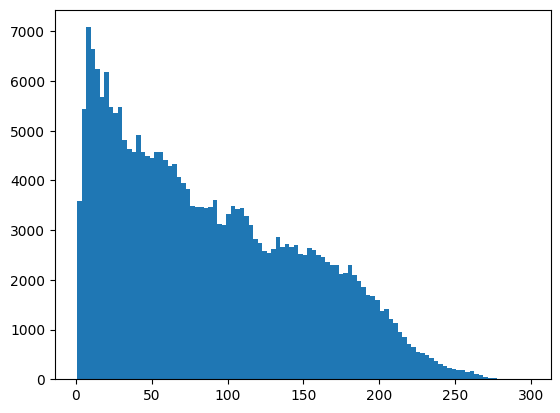

In [40]:
plt.hist(sub.Calories,bins=100)
plt.show()